In [64]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#import wrangle
import env
import seaborn as sns
import acquire
import prep
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split


import prep
import seaborn as sns
from sklearn.cluster import KMeans


import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from math import sqrt
import warnings
from statsmodels.formula.api import ols

In [65]:
#single family residence from zillow DB
df = prep.prep_df()

In [66]:
df.head().T

,0,1,2,3,4
bathrooms,2.000000e+00,4.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00
bedrooms,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00
sqft,3.633000e+03,1.620000e+03,2.077000e+03,1.244000e+03,1.300000e+03
tax_value,2.964250e+05,8.477700e+05,6.467600e+05,1.694710e+05,2.332660e+05
fips,6.037000e+03,6.037000e+03,6.037000e+03,6.037000e+03,6.037000e+03
latitude,3.456002e+07,3.399620e+07,3.401298e+07,3.395356e+07,3.389713e+07
longitude,-1.181698e+08,-1.184380e+08,-1.184792e+08,-1.180839e+08,-1.181030e+08
lotsizesquarefeet,9.826000e+03,1.284275e+04,6.490000e+03,6.021000e+03,4.917000e+03
regionidcity,4.022700e+04,1.244700e+04,2.696400e+04,1.371600e+04,5.363600e+04
regionidcounty,3.101000e+03,3.101000e+03,3.101000e+03,3.101000e+03,3.101000e+03


In [67]:
train, test = train_test_split(df, train_size = .75, random_state = 123)
train['tax_per_sqft'] = train.tax_value/train.sqft

In [68]:
X_train = train.drop(columns=['logerror','fips','latitude','longitude','regionidcity','regionidcounty','regionidzip'])
y_train = train[['logerror']]
X_test = test.drop(columns=['logerror','fips','latitude','longitude','regionidcity','regionidcounty','regionidzip'])
y_test = test[['logerror']]
X_train.tax_value = X_train.tax_value /1000
X_train.structuretaxvaluedollarcnt = X_train.structuretaxvaluedollarcnt/1000


In [69]:
#adding a baseline yhat as mean of log error
train['mean_logerror'] = train.logerror.mean()
train['residual'] = train['logerror']- train['mean_logerror']

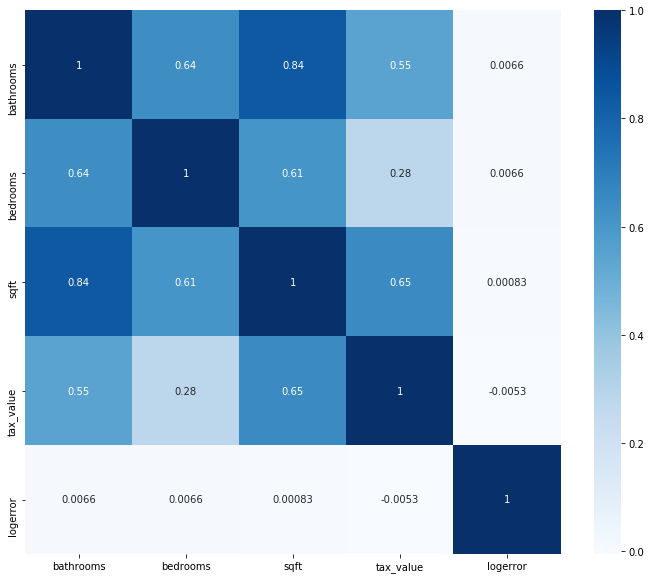

In [70]:
plt.figure(figsize=(12,10))
subset = train[['bathrooms','bedrooms','sqft','tax_value','logerror']]
cor = subset.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Blues)
plt.show()

In [71]:
# MSE of baseline
train['residual^2'] = train.residual ** 2
SSE = sum(train['residual^2'])
MSE = SSE/len(train)
print("MSE = ", MSE)

MSE =  0.028226598428296255


In [72]:
#MSE of sqft and bedrooms as x variables
x = train[['sqft','bedrooms']]
y = train[['logerror']]
ols_model = ols('y ~ x', data=train).fit()
train['yhat'] = ols_model.predict(x)
r2 = ols_model.rsquared
print('r squared = ',round(r2,7))

r squared =  5.88e-05


In [73]:

train['residual^2'] = train.residual ** 2
SSE = sum(train['residual^2'])
MSE = SSE/len(train)
print("MSE = ", MSE)

MSE =  0.028226598428296255


In [104]:
train.groupby('cluster').mean().sort_values(by='logerror')

,bathrooms,bedrooms,sqft,tax_value,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,tax_per_sqft,logerror
cluster,,,,,,,,,
3,2.202970,3.178218,1861.089109,491.927634,10199.396040,1958.336634,175.277515,237.834107,-1.206134
4,2.227214,3.297066,1858.762399,448.783292,10404.345081,1960.708907,174.930372,229.479309,-0.162711
1,2.248233,3.308396,1862.110864,455.408657,9970.128799,1960.999601,176.786122,232.485294,0.015527
0,2.292669,3.334479,1898.924399,460.900275,9847.796136,1961.163230,187.861656,229.040928,0.367101
2,2.241803,3.352459,1799.959016,385.694328,7538.578448,1958.762295,150.343418,220.943611,1.860403


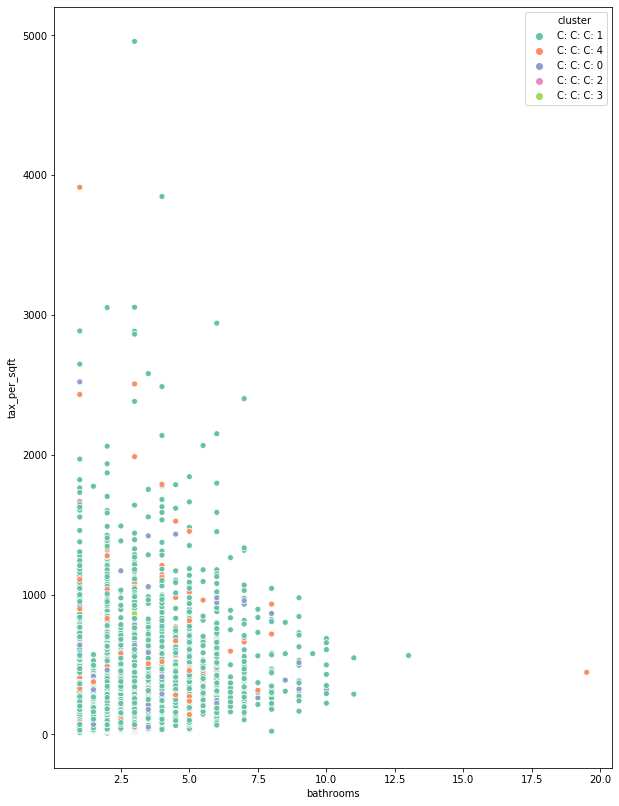

In [108]:
train.cluster = "C: " + train.cluster.astype('str')
figsize = plt.figure(figsize=(10,14))
sns.scatterplot(x='bathrooms',y='tax_per_sqft',data=train,hue='cluster',palette='Set2')

In [74]:
#Model1 performs very slightly better than the baseline
baseline = mean_squared_error(train.logerror,train.mean_logerror)
model1 = mean_squared_error(train.logerror,train.yhat)
print("Baseline: ",baseline)
print("Model1: ",model1)
baseline<model1

Baseline:  0.028226598428296407
Model1:  0.028224938702324065


False

   k           sse
0  1  35576.718402
1  2   2864.795319
2  3    991.530414
3  4    456.156781
4  5    250.586414
5  6    203.075677
6  7    160.072531
7  8    128.896168
8  9     99.121863


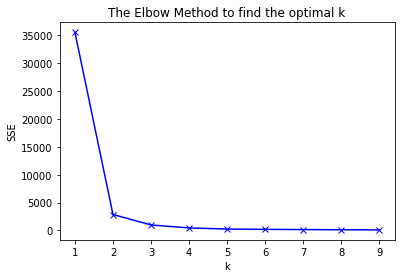

In [82]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(y_train)

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

In [118]:
def target_cluster(y_train,X_train):
    kmeans =KMeans(n_clusters=3)
    kmeans.fit(y_train)
    y_train['cluster'] = kmeans.predict(y_train)
    train = X_train.merge(y_train,left_index=True,right_index=True)
    return train

In [119]:
#Clustered by logerror
train = target_cluster(y_train,X_train)

In [120]:
train.cluster.value_counts()

0    35088
1     3952
2     1868
Name: cluster, dtype: int64

In [88]:
train.groupby('cluster').logerror.mean()

cluster
0    0.367101
1    0.015527
2    1.860403
3   -1.206134
4   -0.162711
Name: logerror, dtype: float64

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [91]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',min_samples_leaf=3,n_estimators=100,max_depth=3, random_state=123)

In [96]:
X = train[['bathrooms','sqft','bedrooms']]
y = train.cluster
X = train[['bathrooms','sqft','bedrooms']]
y = train.cluster

In [97]:
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [98]:
print(rf.feature_importances_)

[0.29597126 0.51010841 0.19392034]


In [110]:
y_pred = pd.DataFrame(rf.predict(X))
y_pred_proba = rf.predict_proba(X)

In [100]:
rf.score(X,y)

0.8577295394543855

In [102]:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1746
           1       0.86      1.00      0.92     35088
           2       0.00      0.00      0.00       122
           3       0.00      0.00      0.00       101
           4       0.00      0.00      0.00      3851

    accuracy                           0.86     40908
   macro avg       0.17      0.20      0.18     40908
weighted avg       0.74      0.86      0.79     40908



In [114]:
y_pred[0].value_counts()

1    40908
Name: 0, dtype: int64